# Import Packages

In [1]:
# --------------------------------------
import pandas as pd
import numpy as np
# --------------------------------------
import requests
import json
# --------------------------------------
# ------------- visualizations:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
# --------------------------------------


# ---------------------------------------
import sklearn
from sklearn import preprocessing, metrics, pipeline, model_selection, feature_extraction 
from sklearn import naive_bayes, linear_model, svm, neural_network, neighbors, tree
from sklearn import decomposition, cluster

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV 
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error, r2_score, silhouette_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder

from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron, SGDClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
# ---------------------------------------


# ----------------- output and visualizations: 
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)
# show several prints in one cell. This will allow us to condence every trick in one cell.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
pd.pandas.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
# ---------------------------------------

# Load API

In [2]:
URL = 'https://data.gov.il/api/3/action/datastore_search?resource_id=ecf37201-e71a-4af5-99a5-062fdf07a38d'
response = requests.get(URL)

In [3]:
response

<Response [200]>

In [4]:
print(response.json()) #see what data we recieve

{'help': 'https://data.gov.il/api/3/action/help_show?name=datastore_search', 'success': True, 'result': {'include_total': True, 'limit': 100, 'records_format': 'objects', 'resource_id': 'ecf37201-e71a-4af5-99a5-062fdf07a38d', 'total_estimation_threshold': None, 'records': [{'_id': 1, 'pk_teuna_fikt': '2018000004', 'sug_tik': '1', 'THUM_GEOGRAFI': '1', 'SUG_DEREH': '1', 'SEMEL_YISHUV': '841', 'REHOV1': '104', 'REHOV2': '105', 'BAYIT': None, 'ZOMET_IRONI': '2', 'KVISH1': None, 'KVISH2': None, 'KM': None, 'ZOMET_LO_IRONI': None, 'YEHIDA': '51', 'SHNAT_TEUNA': '2018', 'HODESH_TEUNA': '9', 'SHAA': '27', 'SUG_YOM': '4', 'YOM_LAYLA': '5', 'YOM_BASHAVUA': '1', 'HUMRAT_TEUNA': '3', 'SUG_TEUNA': '2', 'HAD_MASLUL': '9', 'RAV_MASLUL': '0', 'MEHIRUT_MUTERET': '5', 'TKINUT': '1', 'ROHAV': '3', 'SIMUN_TIMRUR': '3', 'TEURA': '6', 'MEZEG_AVIR': '1', 'PNE_KVISH': '1', 'SUG_EZEM': '9', 'MERHAK_EZEM': '9', 'LO_HAZA': '9', 'OFEN_HAZIYA': '0', 'MEKOM_HAZIYA': '0', 'KIVUN_HAZIYA': '9', 'MAHOZ': '4', 'NAFA': 

In [5]:
def jprint(obj):
    # create a formatted string of the Python JSON object
    text = json.dumps(obj, sort_keys=True, indent=4)
    print(text)

In [6]:
jprint(response.json())

{
    "help": "https://data.gov.il/api/3/action/help_show?name=datastore_search",
    "result": {
        "_links": {
            "next": "/api/3/action/datastore_search?resource_id=ecf37201-e71a-4af5-99a5-062fdf07a38d&offset=100",
            "start": "/api/3/action/datastore_search?resource_id=ecf37201-e71a-4af5-99a5-062fdf07a38d"
        },
        "fields": [
            {
                "id": "_id",
                "type": "int"
            },
            {
                "id": "pk_teuna_fikt",
                "type": "text"
            },
            {
                "id": "sug_tik",
                "type": "text"
            },
            {
                "id": "THUM_GEOGRAFI",
                "type": "text"
            },
            {
                "id": "SUG_DEREH",
                "type": "text"
            },
            {
                "id": "SEMEL_YISHUV",
                "type": "text"
            },
            {
                "id": "REHOV1",
                

# Load to DF

In [7]:
def load_query_result_to_df(response): #offset=12500
    response_json = response.json()
    response_result = response_json['result']
    response_fields = response_result['records']
    total = response_result['total'] #total amount of data
    
    df = pd.DataFrame(response_fields)
    for page_num in range (125):
        url = "https://data.gov.il/api/3/action/datastore_search?resource_id=ecf37201-e71a-4af5-99a5-062fdf07a38d&offset=" + str(page_num*100)
        responseNext = requests.get(url)
        response_json = responseNext.json()
        response_result = response_json['result']
        response_fields = response_result['records']
        df2 = pd.DataFrame(response_fields)
        df = df.append(df2)
    return df

In [8]:
df_results = load_query_result_to_df(response)

In [9]:
df_results

,_id,pk_teuna_fikt,sug_tik,THUM_GEOGRAFI,SUG_DEREH,SEMEL_YISHUV,REHOV1,REHOV2,BAYIT,ZOMET_IRONI,KVISH1,KVISH2,KM,ZOMET_LO_IRONI,YEHIDA,SHNAT_TEUNA,HODESH_TEUNA,SHAA,SUG_YOM,YOM_LAYLA,YOM_BASHAVUA,HUMRAT_TEUNA,SUG_TEUNA,HAD_MASLUL,RAV_MASLUL,MEHIRUT_MUTERET,TKINUT,ROHAV,SIMUN_TIMRUR,TEURA,MEZEG_AVIR,PNE_KVISH,SUG_EZEM,MERHAK_EZEM,LO_HAZA,OFEN_HAZIYA,MEKOM_HAZIYA,KIVUN_HAZIYA,MAHOZ,NAFA,EZOR_TIVI,MAAMAD_MINIZIPALI,ZURAT_ISHUV,STATUS_IGUN,X,Y
0,1,2018000004,1,1,1,841,104,105,None,2,None,None,None,None,51,2018,9,27,4,5,1,3,2,9,0,5,1,3,3,6,1,1,9,9,9,0,0,9,4,42,421,20,31,1,193498,673585
1,2,2018000018,1,1,1,4000,896,825,None,10210522,None,None,None,None,11,2018,6,67,4,1,1,3,2,2,0,1,1,2,3,1,1,1,9,9,9,0,0,9,3,31,311,0,13,1,200041,746160
2,3,2018000030,1,1,1,7100,1035,496,None,10800341,None,None,None,None,38,2018,6,95,4,5,1,2,8,0,3,4,1,3,4,3,1,1,2,2,9,0,0,9,6,61,614,0,14,1,161755,620861
3,4,2018000037,1,1,4,0,None,None,None,None,91,0,80,None,12,2018,7,59,4,1,7,3,8,2,0,4,1,3,3,2,1,1,6,2,9,0,0,9,9,99,999,99,99,1,258984,768332
4,5,2018000049,1,1,3,0,None,None,None,None,4,23,2110,8067,11,2018,1,69,4,5,5,3,2,0,3,1,1,5,3,6,1,1,9,9,9,0,0,9,9,99,999,99,99,1,203320,743957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,12496,2018099555,1,1,1,5000,2216,1301,None,13000556,None,None,None,None,20,2018,9,20,2,5,1,2,2,3,0,1,1,3,3,3,1,1,9,9,9,0,0,9,5,51,511,0,13,1,178801,663121
96,12497,2018099560,1,1,1,5000,1011,180,None,20700111,None,None,None,None,20,2018,3,55,4,1,4,3,2,1,0,1,1,1,3,1,1,1,9,9,9,0,0,9,5,51,511,0,13,1,180659,667465
97,12498,2018099561,1,1,4,0,None,None,None,None,669,0,20,None,14,2018,6,61,4,1,2,3,9,3,0,4,1,3,3,1,1,1,9,9,9,0,0,9,9,99,999,99,99,1,240573,714606
98,12499,2018099577,1,1,2,507,0,None,9999,None,None,None,None,None,12,2018,3,80,4,5,3,3,4,3,0,1,1,3,3,3,1,1,9,9,9,0,0,9,2,24,245,99,28,2,215589,762118


In [10]:
df = df_results.set_index('_id')

## Data Cleaning
Important notes: 
Humrat_Teuna - Severity of accident
Sug_Teuna

In [11]:
def remove_coord_nan(df):
    df_c = df.copy()
    df_c = df.dropna(subset=['X', 'Y'])
    return df_c

In [12]:
def remove_duplicates(df):
    df_c = df.copy()
    df_c.drop_duplicates(keep='first', inplace=True)
    return df_c

In [13]:
df['X'].isna().sum()
df['Y'].isna().sum()
df_coord = remove_duplicates(df)
df_coord = remove_coord_nan(df_coord)
df_coord.shape
df_coord['X'].isna().sum()
df_coord['Y'].isna().sum()

23

23

(12477, 45)

0

0

In [14]:
# Now we can safely drop all columns with missing data
df_cleaned = df_coord.dropna(axis=1)

In [15]:
df_cleaned.isna().sum()

pk_teuna_fikt      0
sug_tik            0
THUM_GEOGRAFI      0
SUG_DEREH          0
SEMEL_YISHUV       0
YEHIDA             0
SHNAT_TEUNA        0
HODESH_TEUNA       0
SHAA               0
SUG_YOM            0
YOM_LAYLA          0
YOM_BASHAVUA       0
HUMRAT_TEUNA       0
SUG_TEUNA          0
HAD_MASLUL         0
RAV_MASLUL         0
MEHIRUT_MUTERET    0
TKINUT             0
ROHAV              0
SIMUN_TIMRUR       0
TEURA              0
MEZEG_AVIR         0
PNE_KVISH          0
SUG_EZEM           0
MERHAK_EZEM        0
LO_HAZA            0
OFEN_HAZIYA        0
MEKOM_HAZIYA       0
KIVUN_HAZIYA       0
MAHOZ              0
NAFA               0
EZOR_TIVI          0
ZURAT_ISHUV        0
STATUS_IGUN        0
X                  0
Y                  0
dtype: int64

In [16]:
df_cleaned.dtypes #We notice the wrong data type. To convert it, we must handle all the nones first. We did that above.
df_cleaned = df_cleaned.astype(np.int64)
df_cleaned.dtypes

pk_teuna_fikt      object
sug_tik            object
THUM_GEOGRAFI      object
SUG_DEREH          object
SEMEL_YISHUV       object
YEHIDA             object
SHNAT_TEUNA        object
HODESH_TEUNA       object
SHAA               object
SUG_YOM            object
YOM_LAYLA          object
YOM_BASHAVUA       object
HUMRAT_TEUNA       object
SUG_TEUNA          object
HAD_MASLUL         object
RAV_MASLUL         object
MEHIRUT_MUTERET    object
TKINUT             object
ROHAV              object
SIMUN_TIMRUR       object
TEURA              object
MEZEG_AVIR         object
PNE_KVISH          object
SUG_EZEM           object
MERHAK_EZEM        object
LO_HAZA            object
OFEN_HAZIYA        object
MEKOM_HAZIYA       object
KIVUN_HAZIYA       object
MAHOZ              object
NAFA               object
EZOR_TIVI          object
ZURAT_ISHUV        object
STATUS_IGUN        object
X                  object
Y                  object
dtype: object

pk_teuna_fikt      int64
sug_tik            int64
THUM_GEOGRAFI      int64
SUG_DEREH          int64
SEMEL_YISHUV       int64
YEHIDA             int64
SHNAT_TEUNA        int64
HODESH_TEUNA       int64
SHAA               int64
SUG_YOM            int64
YOM_LAYLA          int64
YOM_BASHAVUA       int64
HUMRAT_TEUNA       int64
SUG_TEUNA          int64
HAD_MASLUL         int64
RAV_MASLUL         int64
MEHIRUT_MUTERET    int64
TKINUT             int64
ROHAV              int64
SIMUN_TIMRUR       int64
TEURA              int64
MEZEG_AVIR         int64
PNE_KVISH          int64
SUG_EZEM           int64
MERHAK_EZEM        int64
LO_HAZA            int64
OFEN_HAZIYA        int64
MEKOM_HAZIYA       int64
KIVUN_HAZIYA       int64
MAHOZ              int64
NAFA               int64
EZOR_TIVI          int64
ZURAT_ISHUV        int64
STATUS_IGUN        int64
X                  int64
Y                  int64
dtype: object

# Find correlations

In [22]:
def get_highly_correlated_cols(df):
    col_corr = set()
    correlations = []
    tuple_arr = []
    for i in range (len(df.corr().columns)):
        for j in range(i):
            if(df.corr().iloc[j, i] >= 0.5) and (df.corr().columns[i] not in col_corr):
                correlations.append(df.corr().iloc[i, j])
                tuple_arr.append([j, i])
    return correlations, tuple_arr

In [23]:
cols_for_correlations = df_cleaned.columns #select the columns for comparison

In [24]:
correlations, tuple_arr = get_highly_correlated_cols(df_cleaned[cols_for_correlations])
#df_cleaned.corr(method='pearson')

In [25]:
correlations
tuple_arr

[0.6512532834044843,
 0.6237177531264072,
 0.5558626077616236,
 0.5066076047026706,
 0.7598023492233636,
 0.6923255187837946,
 0.6179056809817473,
 0.7971905911176503,
 0.7229347414307994,
 0.6489433752093122,
 0.8996914625361082,
 0.8266361627051051,
 0.6562073715761796,
 0.7478370125140771,
 0.6370284754454293,
 0.7753776851526791,
 0.655528710313167,
 0.9979501894963037,
 0.7772784985129841,
 0.6567775099399579,
 0.997665999687314,
 0.9999848221055472,
 0.9036085788309486,
 0.7295259950723164,
 0.8641372549598221,
 0.8905953420339047,
 0.892410633518484,
 0.5101586246985781]

[[3, 16],
 [14, 19],
 [14, 20],
 [19, 20],
 [14, 21],
 [19, 21],
 [20, 21],
 [14, 22],
 [19, 22],
 [20, 22],
 [21, 22],
 [23, 24],
 [26, 27],
 [3, 29],
 [16, 29],
 [3, 30],
 [16, 30],
 [29, 30],
 [3, 31],
 [16, 31],
 [29, 31],
 [30, 31],
 [3, 32],
 [16, 32],
 [29, 32],
 [30, 32],
 [31, 32],
 [34, 35]]

In [26]:
def plot_high_correlated_scatters(df):
    #fig, axes = plt.subplots(1, len(correlations), figsize = (20, 5))
    fig, axes = plt.subplots(nrows=len(correlations), ncols=1, figsize = (100, 100))
    axe_index = 0
    index_sort = np.argsort(correlations)

    for n_correlation in index_sort:
        col_lt, col_rt = tuple_arr[n_correlation]
        col_left_title, col_right_title = cols_for_correlations[col_lt], cols_for_correlations[col_rt]
        title = "corr('%s', '%s') = %4.2f" % (col_left_title, col_right_title, correlations[n_correlation])
        df.plot(x = col_left_title, y = col_right_title, kind = "scatter",
                ax = axes[axe_index], title = title, xlabel = col_left_title, ylabel = col_right_title)
        axe_index = axe_index + 1

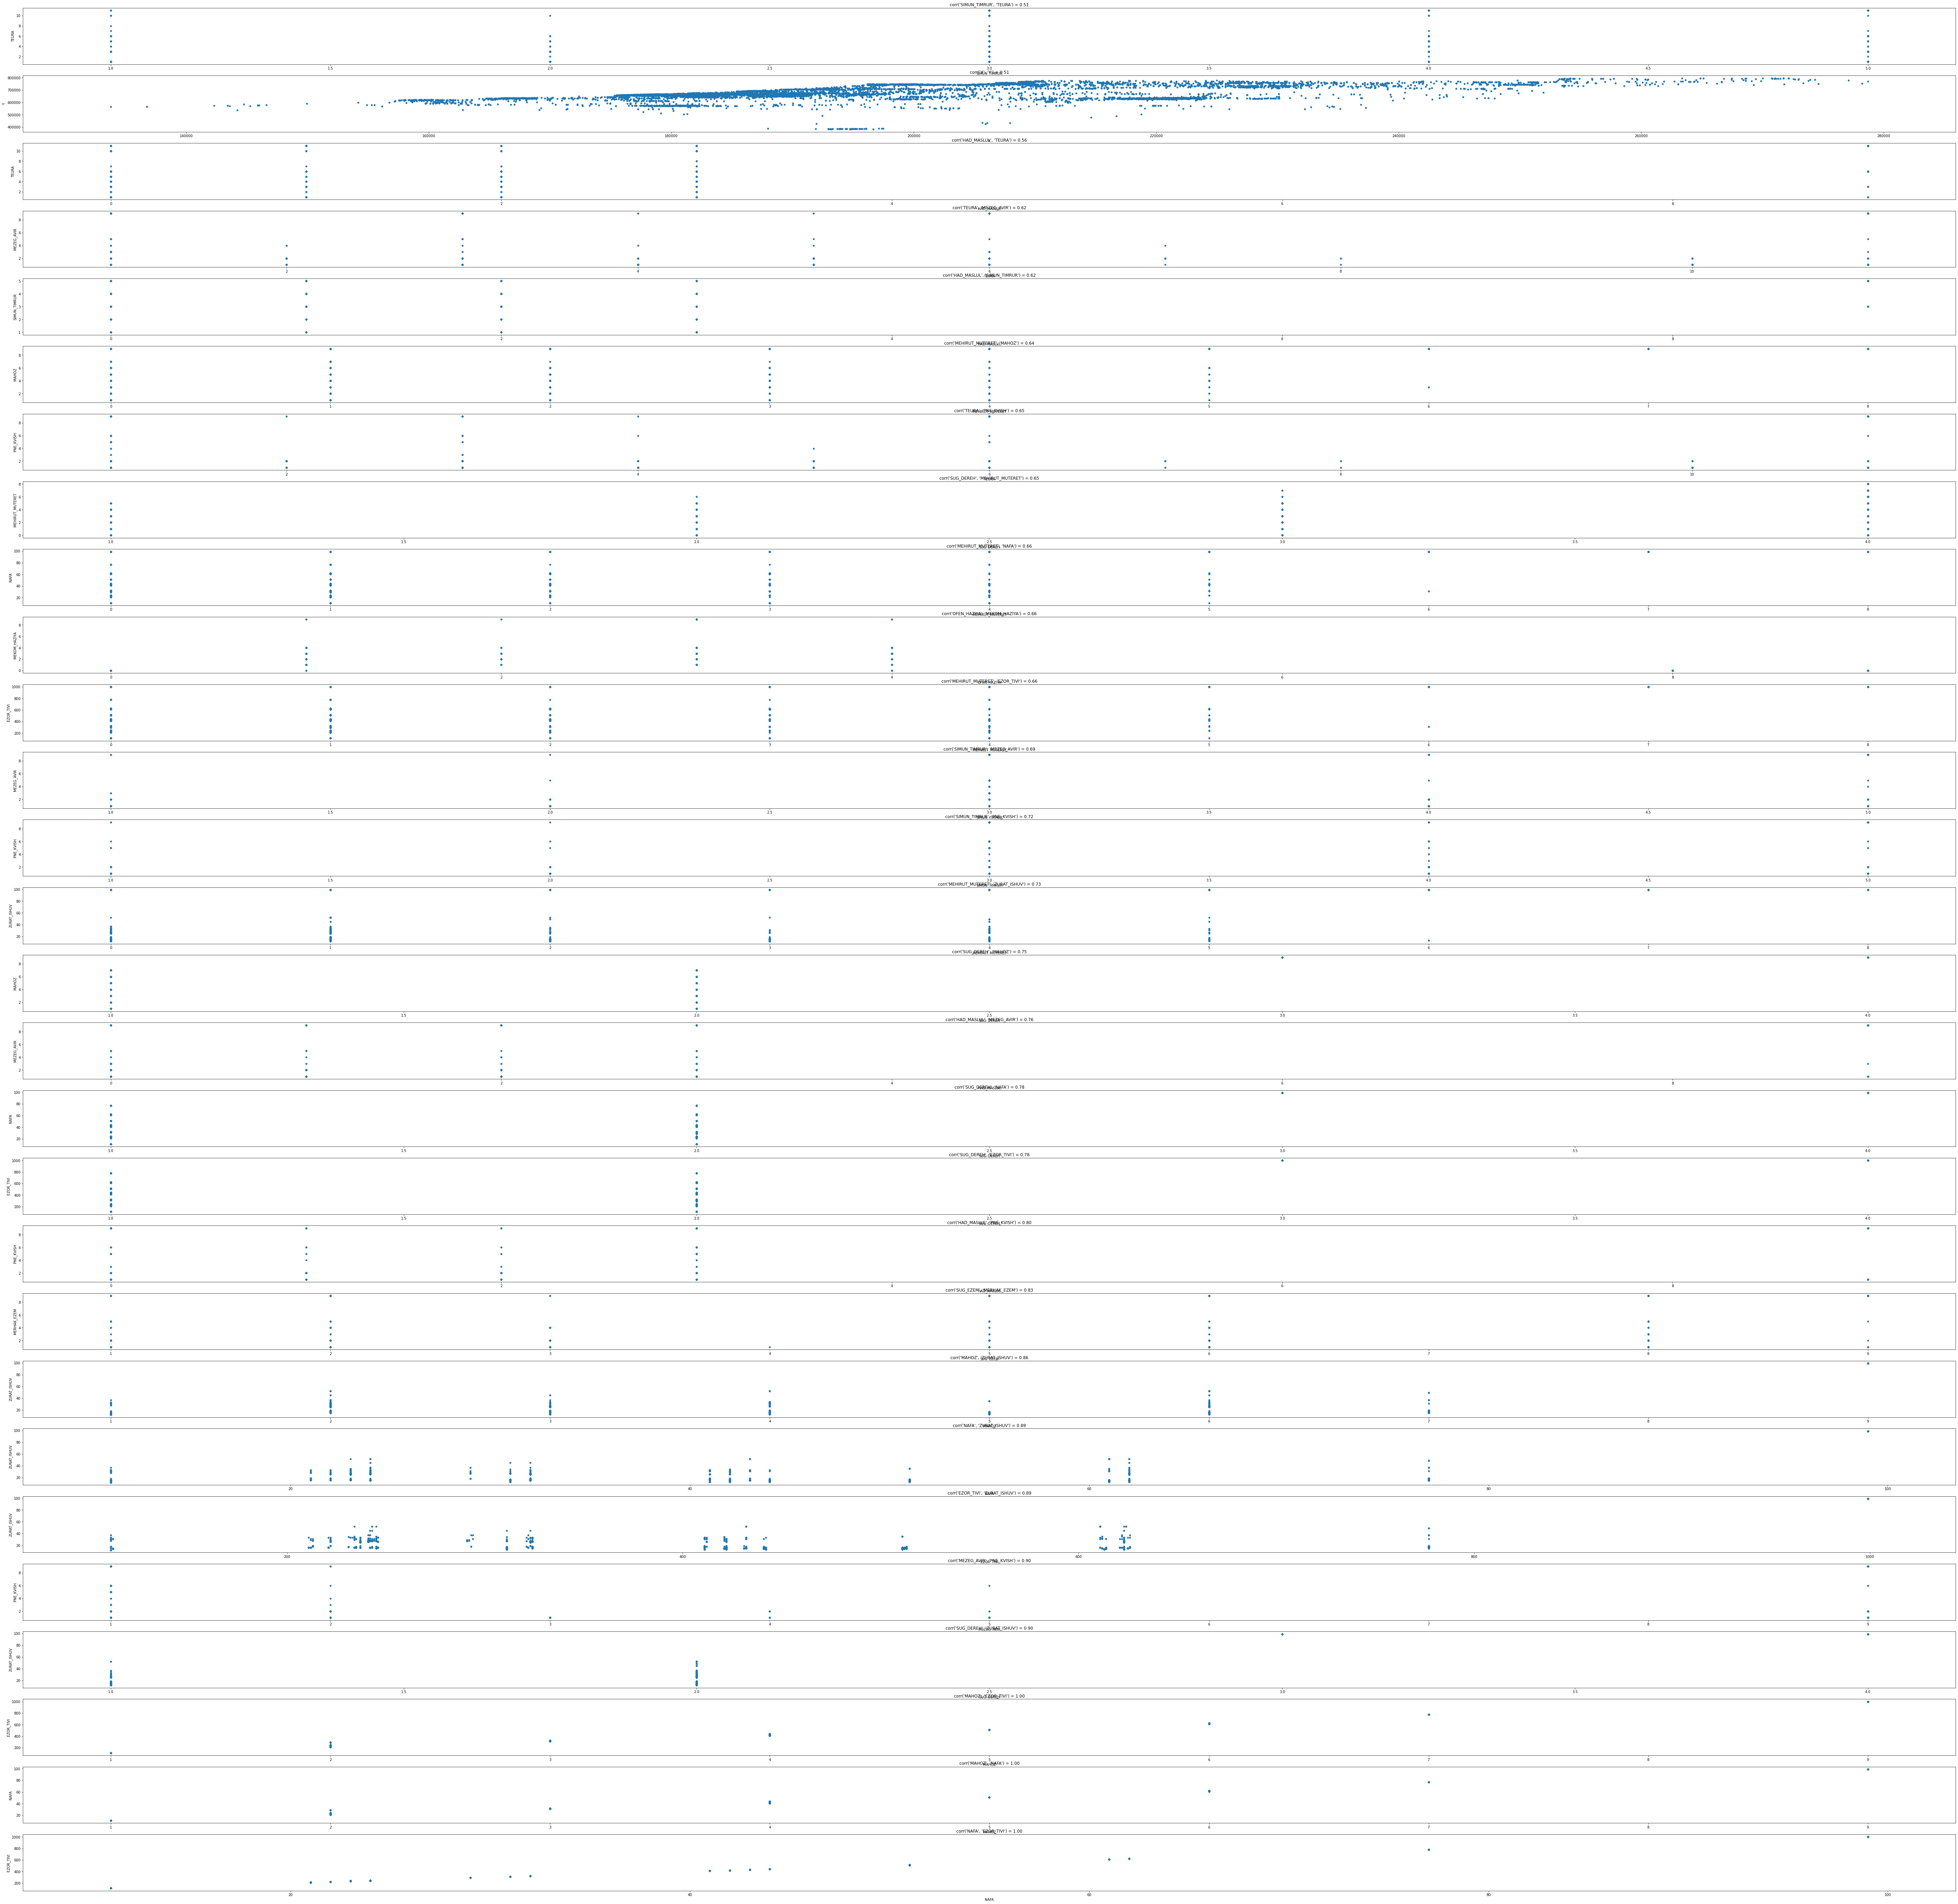

In [27]:
plot_high_correlated_scatters(df_cleaned)

In [146]:
def get_corr_cols(df,tuple_arr):
    feature_to_remove = set()
    num_of_col = np.array(tuple_arr)[:,1]
    for num in num_of_col:
        if num != 35 and num != 34:
            feature_to_remove.add(df.columns[num])
    return feature_to_remove

In [154]:
#X = 34 #Must keep
#Y = 35 #Must keep
tuple_arr.sort()
tuple_arr
correlated_features = get_corr_cols(df_cleaned,tuple_arr)

[[3, 16],
 [3, 29],
 [3, 30],
 [3, 31],
 [3, 32],
 [14, 19],
 [14, 20],
 [14, 21],
 [14, 22],
 [16, 29],
 [16, 30],
 [16, 31],
 [16, 32],
 [19, 20],
 [19, 21],
 [19, 22],
 [20, 21],
 [20, 22],
 [21, 22],
 [23, 24],
 [26, 27],
 [29, 30],
 [29, 31],
 [29, 32],
 [30, 31],
 [30, 32],
 [31, 32],
 [34, 35]]

In [155]:
df_cleaned.drop(labels=correlated_features, axis=1)

,pk_teuna_fikt,sug_tik,THUM_GEOGRAFI,SUG_DEREH,SEMEL_YISHUV,YEHIDA,SHNAT_TEUNA,HODESH_TEUNA,SHAA,SUG_YOM,YOM_LAYLA,YOM_BASHAVUA,HUMRAT_TEUNA,SUG_TEUNA,HAD_MASLUL,RAV_MASLUL,TKINUT,ROHAV,SUG_EZEM,LO_HAZA,OFEN_HAZIYA,KIVUN_HAZIYA,STATUS_IGUN,X,Y
_id,,,,,,,,,,,,,,,,,,,,,,,,,
1,2018000004,1,1,1,841,51,2018,9,27,4,5,1,3,2,9,0,1,3,9,9,0,9,1,193498,673585
2,2018000018,1,1,1,4000,11,2018,6,67,4,1,1,3,2,2,0,1,2,9,9,0,9,1,200041,746160
3,2018000030,1,1,1,7100,38,2018,6,95,4,5,1,2,8,0,3,1,3,2,9,0,9,1,161755,620861
4,2018000037,1,1,4,0,12,2018,7,59,4,1,7,3,8,2,0,1,3,6,9,0,9,1,258984,768332
5,2018000049,1,1,3,0,11,2018,1,69,4,5,5,3,2,0,3,1,5,9,9,0,9,1,203320,743957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12496,2018099555,1,1,1,5000,20,2018,9,20,2,5,1,2,2,3,0,1,3,9,9,0,9,1,178801,663121
12497,2018099560,1,1,1,5000,20,2018,3,55,4,1,4,3,2,1,0,1,1,9,9,0,9,1,180659,667465
12498,2018099561,1,1,4,0,14,2018,6,61,4,1,2,3,9,3,0,1,3,9,9,0,9,1,240573,714606


# Machine Learning